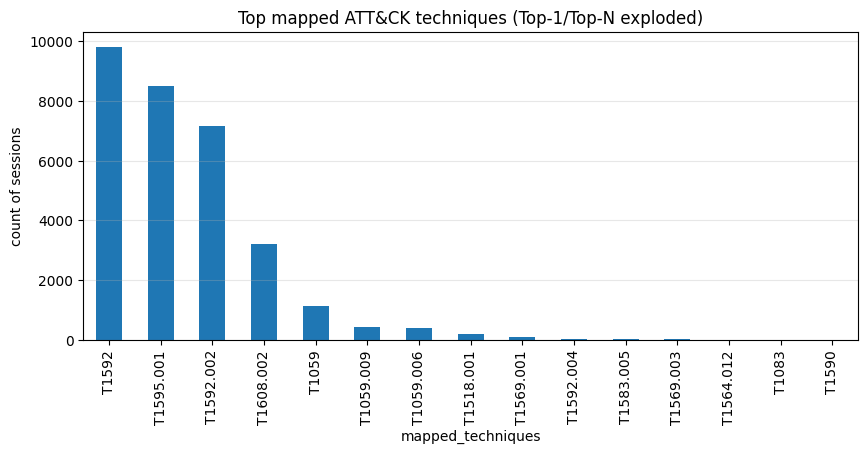

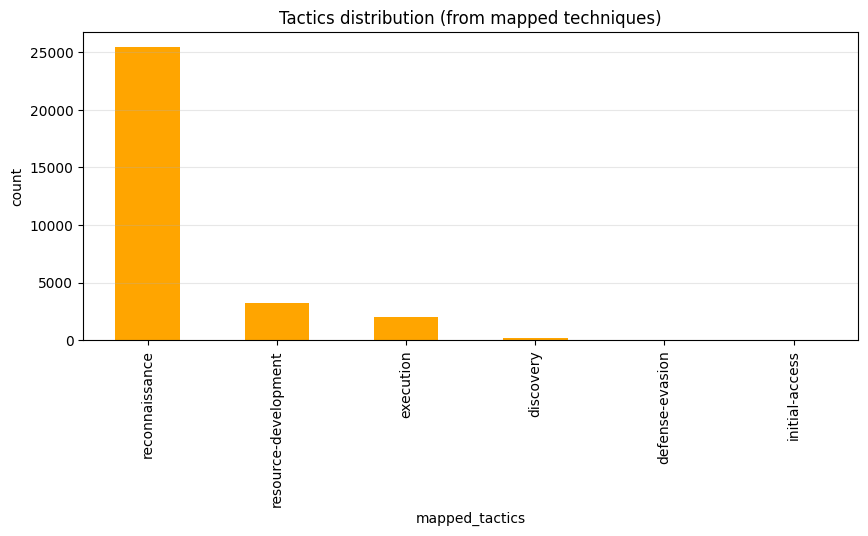

,session_id,src_ip,label,tool,suspicious_score,start_ts,summary,mapped_techniques,mapped_names,mapped_tactics,confidence,why
0,00056990-8a66-5ff3-983e-94a5e16dd4b4,167.94.138.124,suspicious,browser/unknown,0.666845,2023-07-04 16:45:10+00:00,tool=browser/unknown label=suspicious src_ip=1...,"[T1592, T1595.001, T1608.002]","[Gather Victim Host Information, Scanning IP B...","[[reconnaissance], [reconnaissance], [resource...",0.589943,"[indicator:cmd_injection, behavior:burst_rps>=3]"
1,0007b043-0c56-516a-8fe6-6423331514d1,51.103.72.85,suspicious,browser/unknown,0.455866,2023-01-12 20:35:28+00:00,tool=browser/unknown label=suspicious src_ip=5...,"[T1592, T1595.001, T1592.002]","[Gather Victim Host Information, Scanning IP B...","[[reconnaissance], [reconnaissance], [reconnai...",0.551096,[indicator:cmd_injection]
2,000bbed1-88e9-5a4f-88fb-e4f188659e44,104.219.237.43,suspicious,browser/unknown,0.455866,2023-09-11 18:39:58+00:00,tool=browser/unknown label=suspicious src_ip=1...,"[T1592, T1595.001, T1592.002]","[Gather Victim Host Information, Scanning IP B...","[[reconnaissance], [reconnaissance], [reconnai...",0.544944,[indicator:cmd_injection]
3,00105ab5-c299-56db-8554-18dd2d9dbacf,83.97.73.89,suspicious,browser/unknown,0.539957,2023-06-05 12:43:51+00:00,tool=browser/unknown label=suspicious src_ip=8...,"[T1592, T1592.002, T1595.001]","[Gather Victim Host Information, Software, Sca...","[[reconnaissance], [reconnaissance], [reconnai...",0.550536,[indicator:cmd_injection]
4,00159d5f-9fee-59e5-b96a-2b7315541acd,216.218.206.69,suspicious,browser/unknown,0.512218,2023-05-03 04:53:48+00:00,tool=browser/unknown label=suspicious src_ip=2...,"[T1592, T1592.002, T1595.001]","[Gather Victim Host Information, Software, Sca...","[[reconnaissance], [reconnaissance], [reconnai...",0.547939,[indicator:cmd_injection]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

m = pd.read_parquet("../data/processed/session_attack_mapping.parquet")

# explode top techniques + tactics
tech = m.explode("mapped_techniques")
tac = m.explode("mapped_tactics")

# ---- 1) Top techniques bar chart ----
top_tech = tech["mapped_techniques"].value_counts().head(15)

plt.figure(figsize=(10, 4))
top_tech.plot(kind="bar")
plt.title("Top mapped ATT&CK techniques (Top-1/Top-N exploded)")
plt.ylabel("count of sessions")
plt.grid(axis="y", alpha=0.3)
plt.show()

# ---- 2) Tactics distribution ----
# mapped_tactics is a list per technique; after explode it can still be list-of-tactics
# so explode twice safely
tac2 = tac.explode("mapped_tactics")
top_tac = tac2["mapped_tactics"].value_counts().head(15)

plt.figure(figsize=(10, 4))
top_tac.plot(kind="bar", color="orange")
plt.title("Tactics distribution (from mapped techniques)")
plt.ylabel("count")
plt.grid(axis="y", alpha=0.3)
plt.show()

m.head(5)

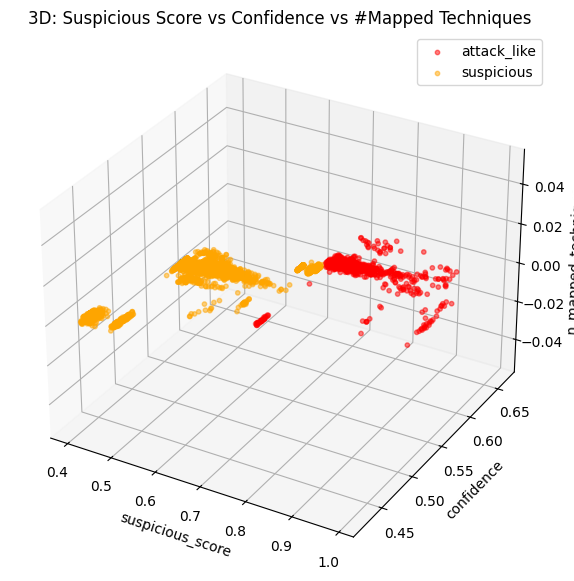

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

m = pd.read_parquet("../data/processed/session_attack_mapping.parquet").copy()

# derived features from mapping parquet
m["n_mapped_techniques"] = m["mapped_techniques"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)
m["n_mapped_tactics"] = m["mapped_tactics"].apply(
    lambda x: (
        sum(len(t) if isinstance(t, list) else 1 for t in x)
        if isinstance(x, list)
        else 0
    )
)
m["hour_utc"] = pd.to_datetime(m["start_ts"], utc=True, errors="coerce").dt.hour.fillna(
    0
)

color_map = {
    "benign": "green",
    "suspicious": "orange",
    "attack_like": "red",
}

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for lbl, g in m.groupby("label"):
    ax.scatter(
        g["suspicious_score"],
        g["confidence"],
        g["n_mapped_techniques"],
        s=10,
        alpha=0.5,
        color=color_map.get(lbl, "gray"),
        label=lbl,
    )

ax.set_title("3D: Suspicious Score vs Confidence vs #Mapped Techniques")
ax.set_xlabel("suspicious_score")
ax.set_ylabel("confidence")
ax.set_zlabel("n_mapped_techniques")
ax.legend()
plt.show()

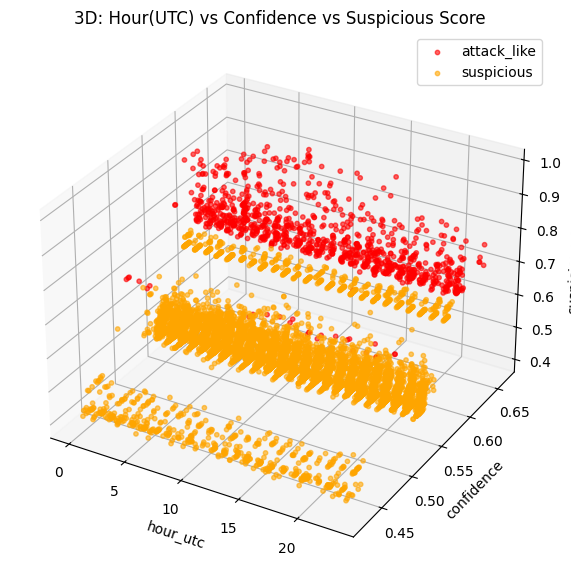

In [3]:
# Cell 3: 3D scatter (time-of-day behavior view)
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for lbl, g in m.groupby("label"):
    ax.scatter(
        g["hour_utc"],
        g["confidence"],
        g["suspicious_score"],
        s=10,
        alpha=0.6,
        color=color_map.get(lbl, "gray"),
        label=lbl,
    )

ax.set_title("3D: Hour(UTC) vs Confidence vs Suspicious Score")
ax.set_xlabel("hour_utc")
ax.set_ylabel("confidence")
ax.set_zlabel("suspicious_score")
ax.legend()
plt.show()